# INF200 Lecture No. Ju04

### Hans Ekkehard Plesser
### 3 June 2021

## Today's topics

- Expected model dynamics (single location)
- A little more on random selection
- Packaging your code for distribution
- Running tests with Tox and running tests on GitLab
- Creating documentation with Sphinx

-------------------

## Expected model dynamics

To provide you with a reference for expected model dynamics, I have run 

- 50 different simulations with only herbivores in a single Lowland location
- 50 different simulations with herbivores and carnivores in a single Lowland location

All simulations use default parameters.

- All animals have identical initial parameters.
- Carnivores are added after 50 years
- Simulation scripts slightly modified from `mono_ho.py` and `mono_hc.py`.

### Simulation script (herbivores and carnivores)

This script uses an additional feature in `BioSim` (not required in the project description) allowing the user to specify a `log_file`. For each year, the number of herbivores and carnivores on the island is written to the file.

The loop in the script is over different simulations, with a different random generator seed for each simulation. Output file names include the seed value.

```python
import textwrap
from biosim.simulation import BioSim

geogr = """WWW
           WLW
           WWW"""
geogr = textwrap.dedent(geogr)

ini_herbs = [{'loc': (2, 2),
              'pop': [{'species': 'Herbivore',
                       'age': 5,
                       'weight': 20}
                      for _ in range(50)]}]
ini_carns = [{'loc': (2, 2),
              'pop': [{'species': 'Carnivore',
                       'age': 5,
                       'weight': 20}
                      for _ in range(20)]}]

for seed in range(100, 150):
    sim = BioSim(geogr, ini_herbs, seed=seed, vis_years=0,
                 log_file=f'data/mono_hc_{seed:05d}.csv')
    sim.simulate(50)
    sim.add_population(ini_carns)
    sim.simulate(251)
```

### Sample log file

```
# Year, Herbivore Count, Carnivore Count
0, 50, 0
1, 48, 0
2, 90, 0
...
298, 83, 45
299, 97, 43
300, 89, 46
```

### Analysing data

#### Herbivore only

In [2]:
import pandas as pd
import numpy as np
from pathlib import Path
import re

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (12, 6)

In [3]:
data = []
for logfile in Path('../../../biosimtest/examples/data').glob('mono_ho_*.csv'):
    d = pd.read_csv(logfile, skiprows=1, usecols=[0, 1], index_col=0,
                    names=['Year', 'Herbivores'])
    d['Seed'] = int(re.match(r'.*_(\d+)\.csv', str(logfile)).group(1))
    data.append(d)
hd = pd.concat(data).pivot(columns='Seed')
hd.head()

Herbivores                                               ...            \
Seed        100  101  102  103  104  105  106  107  108  109  ...  139  140   
Year                                                          ...             
0            50   50   50   50   50   50   50   50   50   50  ...   50   50   
1            48   50   50   49   45   47   50   47   48   47  ...   49   49   
2            78   84   88   85   76   76   87   76   82   81  ...   84   75   
3            88  104  112  103  101   99  106   98  104  100  ...  104   94   
4            93  109  111  106  109  101  113  106  108  102  ...  102  101   

                                             
Seed  141  142  143  144  145 146  147  148  
Year                                         
0      50   50   50   50   50  50   50   50  
1      45   49   48   46   48  47   46   49  
2      82   85   86   81   77  77   84   83  
3     104   99  111  100   94  88  104   98  
4     105  108  117   98  105  97  107  105  

[5 rows x 49 columns]

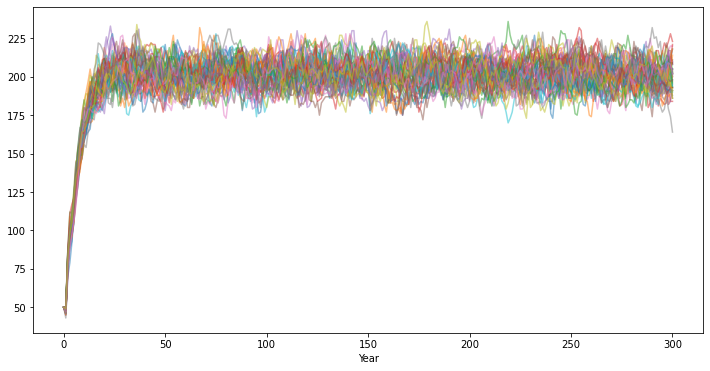

In [4]:
hd.Herbivores.plot(legend=False, alpha=0.5);

Compute some statistics for the late part of he simulation, after the initial transition. We set the limit somewhat arbitrarily at 100 years.

In [5]:
hd_eq = hd.loc[hd.index >= 100, :]

Look first at mean and standard deviation for each individual simulation.

In [6]:
hd_eq.mean()

            Seed
Herbivores  100     201.865672
            101     202.512438
            102     204.840796
            103     201.756219
            104     203.522388
            105     203.338308
            106     200.447761
            107     202.094527
            108     202.293532
            109     198.194030
            110     199.203980
            111     203.358209
            112     200.393035
            113     202.746269
            114     199.507463
            115     201.029851
            116     203.900498
            117     204.039801
            118     200.910448
            119     199.870647
            120     200.651741
            121     204.049751
            122     200.308458
            123     203.248756
            124     203.094527
            125     202.059701
            126     202.815920
            127     200.741294
            128     200.069652
            129     200.955224
            130     202.462687
            131     20

In [7]:
hd_eq.std()

            Seed
Herbivores  100      7.971629
            101      8.563358
            102      9.584598
            103      9.518680
            104      8.945991
            105      9.013599
            106      9.844720
            107      9.359275
            108     10.028380
            109      9.077839
            110      8.080420
            111      7.177816
            112      7.952343
            113     10.169577
            114      9.473183
            115      9.324114
            116      8.047363
            117     10.390304
            118      9.119317
            119      8.945009
            120      9.618633
            121      8.166242
            122      7.430638
            123      8.667053
            124     10.518366
            125      8.120740
            126      8.944325
            127     10.172155
            128     11.014768
            129      8.499587
            130      6.725314
            131     10.776266
            132      9.

Values are consistent across simulations.

Now combine data from all simulations and compute overall mean and std.

In [8]:
hd_eq.unstack().mean()

201.75357904355772

In [9]:
hd_eq.unstack().std()

9.175753334885586

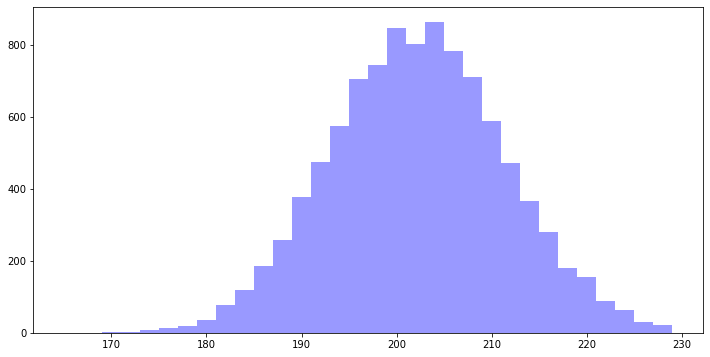

In [10]:
bins = np.arange(165, 230, 2)
plt.hist(hd_eq.Herbivores.unstack(), bins=bins, fc='b', histtype='stepfilled', alpha=0.4);

#### Summary for herbivores only

- 201.8 ± 9.2 herbivores
- Distribution looks reasonably normal, but with some surprising peaks
- When checking your simulation, if your animal count is around 200 in the long run, things are probably fine.

### Herbivores and Carnivores

In [11]:
data = []
for logfile in Path('../../../biosimtest/examples/data').glob('mono_hc_*.csv'):
    d = pd.read_csv(logfile, skiprows=1, index_col=0,
                    names=['Year', 'Herbivores', 'Carnivores'])
    d['Seed'] = int(re.match(r'.*_(\d+)\.csv', str(logfile)).group(1))
    data.append(d)
hc = pd.concat(data).pivot(columns='Seed')
hc.tail()

Herbivores                                        ... Carnivores          \
Seed        100 101 102 103 104 105  106 107 108  109  ...        139 140 141   
Year                                                   ...                      
296          87  87  86  84  82  75   99  75  55  210  ...         24  61  37   
297          79  89  90  86  80  83   96  75  55  192  ...         21  62  41   
298          83  83  91  87  86  85   98  69  47  198  ...         18  63  42   
299          97  85  83  74  79  75  100  74  42  198  ...         21  59  38   
300          89  80  94  79  84  75   84  70  47  201  ...         24  53  32   

                                  
Seed 142 143 144 145 146 147 148  
Year                              
296   46  37   0  46  36  43  46  
297   50  34   0  42  43  41  48  
298   53  27   0  45  46  39  47  
299   49  32   0  46  49  36  52  
300   52  33   0  50  52  41  50  

[5 rows x 98 columns]

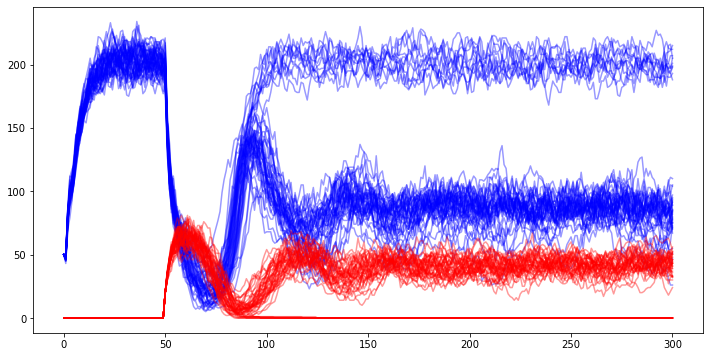

In [12]:
plt.plot(hc.Herbivores, 'b', alpha=0.4);
plt.plot(hc.Carnivores, 'r', alpha=0.4);

- We see two regimes: in some cases, carnivores die out befoe year 100, in others not
- Check in how many cases carnivores die out

In [13]:
sum(hc.loc[300, 'Carnivores'] == 0)

11

In [14]:
sum(hc.loc[300, 'Herbivores'] == 0)

0

Pick out those cases where Carnivores survive until the end, plot to check the picking worked right.

In [15]:
with_c = hc.loc[300, 'Carnivores'] > 0
hc_eq = hc.loc[hc.index >= 175, np.hstack((with_c.values, with_c.values))]

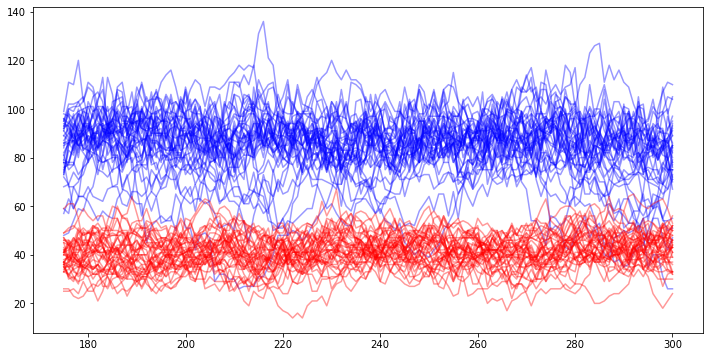

In [16]:
plt.plot(hc_eq.Herbivores, 'b', alpha=0.4);
plt.plot(hc_eq.Carnivores, 'r', alpha=0.4);

Look at averages

In [17]:
hc_eq.Herbivores.unstack().mean(), hc_eq.Herbivores.unstack().std()

(85.35317460317461, 12.868571075539952)

In [18]:
hc_eq.Carnivores.unstack().mean(), hc_eq.Carnivores.unstack().std()

(41.31934001670844, 7.087544265039143)

- 85.4 ± 12.9 herbivores
- 41.3 ± 7.1 carnivores

in those cases where both herbivores and carnivores survive.

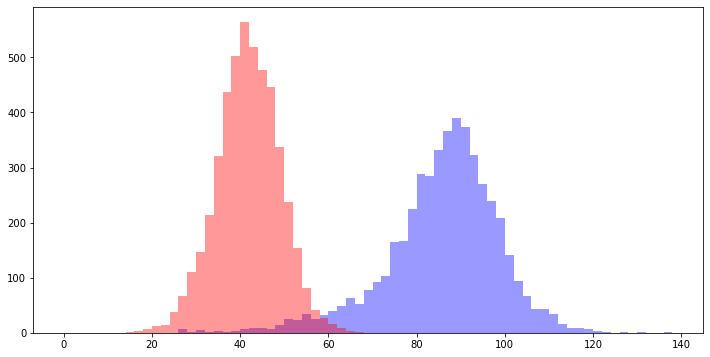

In [19]:
bins = np.arange(0, 140, 2)
plt.hist(hc_eq.Herbivores.unstack(), bins=bins, fc='b', histtype='stepfilled', alpha=0.4);
plt.hist(hc_eq.Carnivores.unstack(), bins=bins, fc='r', histtype='stepfilled', alpha=0.4);

-------------

## A little more on random selection

### Case 1: Dead or alive

- An animal has a probability $p$ to die
- How do we decided if the animal will die in a given year?
    - Draw uniformly distributed random number from $[0, 1)$ and compare to $p$
    
### Case 2: Choosing between multiple alternaives

- Literature: Knuth, The Art of Computer Programming, vol 2, ch 3.3-3.4 
- In a simluation, we want to choose between four alternatives with probabilities $p_0, p_1, p_2, p_3$
- Note $\sum_{n=0}^3 p_n = 1$ by definition
- Cumulative probabilities $P_n = \sum_{k=0}^n p_k$ divide unit interval in sections corresponding to events 0, 1, 2, 3
- Specifically, we choose a random number $r$ and select 

\begin{equation}
\begin{cases}
\text{event}\: 0 \quad\text{if}\; r < P_0 \\
\text{event}\: n \quad\text{if}\; P_{n-1} \leq r < P_{n}\;\; \text{for}\; n>0
\end{cases}
\end{equation}

- The following code will select from `len(p)` alternatives with probabilities `p[0]`, `p[1]`, ...

In [19]:
def random_select(p):
    r = random.random()
    n = 0
    while r >= p[n]:
        r -= p[n]
        n += 1
    return n

### Simpler approach for our simulations

- Animals move in all four directions with *same* probability
- Can use `random.choice()` to pick one element from a list with equal probability

----------------

## Packaging your code for distribution

Let us say you have spent the last year creating some really great Python code, and now you want to share it with others. What do we need to do?
- Need to put "everything together" into a nice "parcel"
- Need to handle *dependencies* (e.g., that our code needs NumPy)
- Need to "spread the word (code)"

**Python solution**: *Packaging*

#### Packages *vs* Packages

You might have noted that we now have to different things called *packages*, they are either
- Collections of modules (import packages)
- A collection of code neatly packaged for sharing with others (distribution packages)

Yes, having the same name for two different things is confusing. Programmers are horrible at naming conventions, we just have to deal with that

The [Python Packaging User Guide Glossary](https://packaging.python.org/glossary/) defines a Distribution Package as

"A versioned archive file that contains Python packages, modules, and other resource files that are used to distribute a Release. The archive file is what an end-user will download from the internet and install."

### Where to share distribution packages?

You have now created a nice distribution package of your code (we will check out the details soon), how do you share it? 
- If it is only with a few people, email, direct transfer, etc is fine
- If you want to keep the code open for everyone to see, github/bitbucket is a nice way to do it
- Alternatively, you can use the [Python Package Index (PyPI)](https://pypi.python.org), aka the "CheeseShop"
- If you want to make it easily available for Conda users, consider creating a [Conda package as well](https://docs.conda.io/projects/conda-build/en/latest/user-guide/tutorials/build-pkgs.html)
    - [Discussion of Conda vs PIP by Jake Vanderplas](https://jakevdp.github.io/blog/2016/08/25/conda-myths-and-misconceptions/)

### Python packaging: a convoluted history

- Creating distribution packages for Python has a long and difficult history
- Pure Python packages reasonably simple, but packages depending, e.g., on optimized numerics libraries such as NumPy were difficult
- Various approaches over time, e.g., setuptools, distutil, eggs, wheels, ...
    - also external package managers such as conda
- Relatively recent standardization
    - [PEP 517 -- A build-system independent format for source trees](https://www.python.org/dev/peps/pep-0517/)
    - [PEP 518 -- Specifying Minimum Build System Requirements for Python Projects](https://www.python.org/dev/peps/pep-0518/)
- Still a lot of outdated or partially up-to-date information out there

## How do we prepare our code for distribution?

We cover only the basics here. 

- Description in the following built on
    - https://packaging.python.org/tutorials/packaging-projects/
    - https://docs.python.org/3/distributing/index.html
    - https://setuptools.readthedocs.io/en/latest/userguide/quickstart.html
    - https://setuptools.readthedocs.io/en/latest/userguide/declarative_config.html
- For more information, see also
    - https://packaging.python.org/guides/distributing-packages-using-setuptools/
    - https://packaging.python.org/guides/

#### Key idea of a distribution package

We want to make sharing Python-based projects easy
- Collect
    - Source code: Python modules, import packages, tests
    - Example scripts
    - Documentation
    - ...
    
    
- Provide *metadata* about the code, e.g.,
    - Purpose, Dependencies, Author information
    - License information, Version information, ...
    
    
- Provide a *build archive*
- Support easy installation to predefined locations

#### Example: Typical distribution package directory layout

```
biolab_project/
   docs/
   examples/
      experiment_01.py
      ...
   src/
       biolab/
          __init__.py
          bacteria.py
          ...
   tests/
       test_bacteria.py
       ...
   .gitlab-ci.yml
   LICENSE
   pyproject.toml
   README.md
   setup.cfg
   setup.py
   tox.ini
```

In our example, `biolab` is an import package included in our distribution, it is the source code. In this example `tests` is placed next to the source code package.

In addition to the `biolab` package we have a folder called `examples`, with some scripts the user can look at to see how the `chutes` packaged can be used. Note that `examples` is *not* a package, as it does not have an `__init__.py` file, it is just a regular folder. If you have a Jupyter notebook with examples, it could also be placed here. `docs` contains documentation, see below.

#### Configuration files

- `LICENSE` includes the license for your code.
    - Choose your license carefully!
    - Do not try to write your own license (unless you are a lawyer, maybe ...).
    - Three major categories of open source licenses
        - Viral licenses, e.g., GNU Public License (GPL)
        - Permissive licenses, e.g., BSD or MIT licenses
        - Other licenses
    - See also
        - https://opensource.org/licenses
        - https://choosealicense.com
- A `README.md` contains a description of the distribution package, and usually contain some information to the user about how to install it and where to look for examples/documentation. The file type is flexible, but [Markdown](https://en.wikipedia.org/wiki/Markdown) is common
- `pyproject.toml` describes the build system for creating your package. It should usually be just

    ```
    [build-system]
    requires = ["setuptools", "wheel"]
    build-backend = "setuptools.build_meta"
    
    ```
    
- `setup.cfg` is the main configuration file describing our package, discussed in more detail below. It is a *declarative* (*static*) configuration file. This is the preferred modern way of providing the configuration information. For details, see comments in `biolab_project/setup.cfg` and links above.
- `setup.py` is an *imperative* (*dynamic*) file used in the past to provide information about package configuration. It can fill the same role as `setup.cfg` and was widely used in the past. If you have a `setup.cfg` file, then `setup.py` can be omitted or should only contain

    ```python
    import setuptools
    setuptools.setup()
    
    ```
- `tox.ini` and `.gitlab-ci.yml` configure testing and will be discussed below.

#### Building a distribution package

- Open a terminal or Anaconda prompt
- Go to the top-level directory for your project, here `biolab_project`
- Make sure you have the correct conda environment activated
- Run
```
python -m build
```
- Python `setuptools` will do all the work
    - Files created in this process are placed in directory `build`
    - The files you can distribute will be placed in `dist`
- In our case we get in `dist` (on Windows, we get `zip` archive instead of `tar.gz`)
    - `biolab-0.1-tar.gz` (plain archive with source files)
    - `biolab-0.1-py3-none-any.whl` (Python Wheel)
- Wheels are current standard Python package distribution archives
    - can handle depdencies on C libraries
    - `none-any` can be replaced with system-specific names if building with C libraries
    - For more, see https://realpython.com/python-wheels/
- Material in `build` or `dist` could confuse PyCharm code inspection, so set `Mark directory as > Excluded` for those directories.
- **Do not commit** the `build` and `dist` directories!
- You could now upload your package to PyPi using `twine`, but we will skip that part in this course.

#### Installing a package 

##### "Manually" from a plain archive

This is the old-fashioned (pre-wheel) way of doing it.

1. Unpack the `tar.gz` or `zip` file
1. Move into the directory that we unpacked
1. Run
   ```
   python setup.py install
   ```

- This will install in the default location for packages in your current Python environment.
- Packages installed like this **cannot** be uninstalled easily.

##### Installing the `pip` way

- If package is available on PyPi, just
  ```
  pip install xyz
  ```
- To install from a local file
  ```
  pip install biolab-0.1-py3-none-any.whl
  ```
- Also installs to default location
- Package can be uninstalled with `pip uninstall biolab`

----------------

## Running tests with Tox and running tests on GitLab

### Tox

- [Tox](https://tox.readthedocs.io/en/latest/index.html) manages environments for controlled running of tests
- Sets up environment according to `setup.cfg` and `tox.ini` specifications and tests in this well-defined enviroment
![Tox flow](https://tox.readthedocs.io/en/latest/_images/tox_flow.png)
- Configured by `tox.ini`, see `biolab_project/tox.ini` for example
- Run in terminal as
```
tox
```
- Places all its files in `.tox` directory, delete this if changes you make to Tox configuration seem to have no effect
- Mark `.tox` directory as `Excluded` in PyCharm
- **Do not commit** the `.tox` directory!

### GitLab test runners

- GitLab (and Github, Travis, Jenkins, ...) can tests automatically for us
- Test on every push to repository
- Good practice, also known as [Continuous Integration Testing (CI)](https://en.wikipedia.org/wiki/Continuous_integration)
- Can be extended to [Continuous Delivery/Deployment (CD)](https://en.wikipedia.org/wiki/Continuous_delivery)
- Requires `.gitlab-ci.yml` file at *top level* of repository
- See `biolab_project/.gitlab-ci.yml` for an example

#### Note
GitLab will not run tests on `biolab_project` inside the `inf200-course-materials`, because it is in a subdirectory. To demonstrate the effect, we need to create a separate repo for `biolab_project`.

------------------

## Creating documentation with Sphinx

### What is Sphinx?

- [Sphinx](http://www.sphinx-doc.org/en/stable/) is a tool for generating documentation for your code
- Can compile documentation to many different formats: LaTeX, pdf, html, etc.
- Can read out docstrings in your code and include in the documentation
- Sphinx-generated documentation can easily be served online, e.g., via [ReadTheDocs](https://readthedocs.org)
    - ReadTheDocs can pick up material from your GitLab/Github repo
    - Automatically updates documentation on very push
    - Can handle multiple versions
    - Configured by `.readthedocs.yml` file at top level in repository
    - Requires ReadTheDocs account
    - We will skip this in this course

![NEST Doc Workflow](https://nest-simulator.readthedocs.io/en/latest/_images/documentation_workflow.png)

### Getting started: `sphinx-quickstart`

1. Open `Terminal` within PyCharm 
    - Alternative: open `Terminal` under OSX/Linux or `Anaconda Prompt` under Windows and navigate to your `biosim-txx-Name1-Name2` folder (use `cd` to change directories)
1. Ensure your `inf200_june` conda environment is activated
1. Run the following command
```
sphinx-quickstart --ext-autodoc --ext-coverage --ext-mathjax --ext-viewcode docs
```
1. Accept default answers for questions by pressing ENTER and enter sensible values for
    - Project Name
    - Author Names(s)
    - Project version
1. Don't worry if you make a mistake, you can fix it in the `docs/conf.py` file
1. Open file `conf.py` in the `docs` directory and change the following lines (approx line 15) 

        #import os
        #import sys
        #sys.path.insert(0, os.path.abspath('.'))
        
    to
    
        import os
        import sys
        sys.path.insert(0, os.path.abspath('../src'))
        autoclass_content = 'both'
        
     The first line ensures that Sphinx finds all code in the project directory, the second that documentation will be generated for all constructors.
1. Finally, add the following line at the end of `conf.py`

        latex_elements = {'papersize': 'a4paper'}

### Write documentation

1. Edit the `docs/index.rst` file and add additional documentation `*.rst` files
1. For a worked example, see `Project/SampleProjects/biolab_project`
1. For more information on restructured text, see
    - [Sphinx ReStructuredText primer](https://www.sphinx-doc.org/en/master/usage/restructuredtext/basics.html)
    - [Another ReStructuredText primer](https://docutils.sourceforge.io/docs/user/rst/quickstart.html)
    - [Full Sphinx ReStructuredText documentation](https://www.sphinx-doc.org/en/master/usage/restructuredtext/index.html)
    
### Generate documents

1. Open a Terminal (e.g. inside PyCharm) and navigate to the `docs`
folder inside your project.

1. Run 

        make html
        
    This will create basic documentation, which you by opening `docs/_build/html/index.html` 
    in a web browser.
    
1. If the command above does not work in the terminal you opened in PyCharm, try opening a normal Terminal, navigate to the `docs` directory and try again.
       
1. To create documentation in other formats, run, e.g.

        make epub
        make latexpdf

    The resulting documentation will be in the `epub` and `latex`
    directories, respectively. Creating these formats may require
    additional software on your computer, especially a working TeX
    system, e.g.

    - Windows: [MikTeX](http://miktex.org)
    - OSX: [MacTex](https://tug.org/mactex)

    Under Windows, you may have to run (replace `biolab` with `biosim`)
    
        ```
        make latex
        cd _build/latex
        pdflatex biolab
        ```
        
    If Sphinx tells you that Perl.exe is missing to build the LaTeX file, you can install Perl using `conda install perl` or install Perl from https://strawberryperl.com (not tested yet).

### Keep Sphinx-generated documentation out of Git repo!

The documentation that is generated in the `docs/_build` directory **should not be committed to your git repository**!

`docs/_build` should automatically be ignored by git if you have put the right `.gitignore` file in place (copied from course repo `project_description/sample.gitignore`.

If the `docs/_build` directory is not ignored by git, proceed as follows:
1. If you have not yet put `.gitignore` in place, do it now and see if `docs/_build` is ignored afterwards.
1. If the `docs/_build` build directory is still not ignored, there are a few possibilities:
    1. The `docs` directory has a different name, e.g. `Docs` or `doc`. Rename it to `docs`.
    1. The `docs` directory is not at the top level within the `BioSim_Txx_Name1_Name2` folder. Move it to the top level.
    1. The `.gitignore` file is not at the top level within the `BioSim_Txx_Name1_Name2` folder. Move it there.
    1. If none of this helps, contact Hans Ekkehard!
1. Commit your changes if you changed `.gitignore` or moved a directory.

### Formatting options for docstrings

Instead of the standard format for docstrings, e.g.,

```
def repeat(text, copies):
    """
    Repeat given text a given number of times.
    
    :param text: a string
    :param copies: an integer
    :return: string, text concatenated copies times
    """
```

one can also use NumPy-style docstrings which look like this

```
"""
Repeat given text a given number of times.

Parameters
----------
text : str
    Text to be repeated
copies : int
    Number of repetitions

Returns
-------
str
    Text concatenated copies times.
"""
```

For more on the NumPyDoc format, see
- http://numpydoc.readthedocs.io/en/latest/format.html
- http://sphinxcontrib-napoleon.readthedocs.io/en/latest/example_numpy.html

To work with NumPyDoc docstrings, you need to do the following:
1. In `docs/conf.py`, around line 40, add `'sphinx.ext.napoleon'` to the list of `extensions`.
1. In PyCharm, open Preferences, go to `Tools > Python integrated tools` and select `Docstring format` NumPy

### Further  documentation on Sphinx

- [Sphinx homepage](http://sphinx-doc.org)
- ["Guided tour" to documenting with Sphinx](http://pythonhosted.org/an_example_pypi_project/sphinx.html)
- [Sphinx tutorial from the Matplotlib folks](http://matplotlib.org/sampledoc/)
- [Documentation tutorial by Brenadn Hasz](https://brendanhasz.github.io/2019/01/05/sphinx.html)
- [A lot of projects using Sphinx for documentation](https://www.sphinx-doc.org/en/master/examples.html)
- [NEST Simulator documentation built with Sphinx](https://nest-simulator.readthedocs.io/en/latest/)
- [NEST Documentation Style Guide](https://github.com/nest/nest-simulator/blob/30c4c6632230cd617195c92b76744250bc40ab4e/doc/userdoc/contribute/styleguide/styleguide.rst)    